In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import multiprocessing

from datasets import *
from transforms import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
valid = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v23v.csv')
test_summary = pd.read_csv('input/signal_summary.csv')
public748 = pd.read_csv('input/public748.csv')

In [4]:
test = pd.concat([test, test_summary.drop('idx', axis=1)], axis=1)

In [5]:
test

id  target  ts_start_h1   ts_end_h1  num_gaps_h1  length_h1  \
0     00054c878     0.5   1238170136  1248567118          303       4639   
1     0007285a3     0.5   1238168014  1248520149          319       4427   
2     00076c5a6     0.5   1238168771  1248535146          281       4599   
3     001349290     0.5   1238170698  1248536462          295       4609   
4     001a52e92     0.5   1238166605  1248534994          314       4601   
...         ...     ...          ...         ...          ...        ...   
7970  ffbce04ef     0.5   1238174572  1248548094          332       4533   
7971  ffc2d976b     0.5   1238178719  1248541890          285       4611   
7972  ffc905909     0.5   1238198490  1248582316          290       4726   
7973  ffe276f3e     0.5   1238167796  1248534967          307       4520   
7974  fffa17f67     0.5   1238166589  1248613429          310       4523   

         max_h1    90%_h1    25%_h1    10%_h1  ts_start_l1   ts_end_l1  \
0     36.596880  5.182469  0.648318  0.236532   1238168574  1248561347   
1     33.348710  5.185728  0.645892  0.236174   1238169747  1248537247   
2     38.125170  5.181007  0.647001  0.236868   1238172441  1248567481   
3     33.123688  5.186102  0.646682  0.236379   1238166901  1248536964   
4     30.006860  5.180545  0.649487  0.237005   1238167190  1248542755   
...         ...       ...       ...       ...          ...         ...   
7970  34.117268  5.175504  0.645922  0.236845   1238173986  1248589023   
7971  35.487473  5.169191  0.647208  0.236513   1238172684  1248539274   
7972  30.702550  5.180704  0.645512  0.236194   1238171186  1248563155   
7973  34.794548  5.182399  0.649433  0.238161   1238167002  1248535419   
7974  36.399986  5.633560  0.699183  0.255716   1238167207  1248542367   

      num_gaps_l1  length_l1     max_l1    90%_l1    25%_l1    10%_l1  
0             324       4566  31.032060  5.172359  0.646489  0.236746  
1             325       4650  35.349796  5.194143  0.648571  0.237914  
2             305       4633  35.410625  5.185566  0.646724  0.237244  
3             322       4621  31.477259  5.177888  0.645992  0.237332  
4             325       4366  31.458930  5.175384  0.647351  0.237881  
...           ...        ...        ...       ...       ...       ...  
7970          318       4634  31.854813  5.188142  0.647497  0.237654  
7971          285       4730  29.164394  5.183527  0.647657  0.236972  
7972          302       4619  31.855278  5.190749  0.646872  0.236676  
7973          305       4533  31.888836  5.174247  0.649748  0.237436  
7974          335       4611  37.469795  4.737347  0.588070  0.214774  

[7975 rows x 18 columns]

# Correlation

In [78]:
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
valid = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v23v.csv')
# public748 = pd.read_csv('input/public748.csv')
# iafoss_v5160 = {
#     'oof': pd.read_csv('input/predictions/val_model_v5_1_6_0.csv'),
#     'pred': pd.read_csv('input/predictions/submission_model_v5_1_6_0.csv')}
# iafoss_v7000 = {
#     'oof': pd.read_csv('input/predictions/val_model_v7_0_0_0.csv'),
#     'pred': pd.read_csv('input/predictions/submission_model_v7_0_0_0.csv')}
# chris_v16 = {
#     'oof': pd.read_csv('input/predictions/valset_16_0.7036.csv'),
#     'pred': pd.read_csv('input/predictions/sub_16_bce_mse.csv')}
# chris_v18 = {
#     'oof': pd.read_csv('input/predictions/valset_18_0.6997.csv'),
#     'pred': pd.read_csv('input/predictions/sub_18_double_model.csv')}
# drhb_exp200 = {
#     'oof': pd.read_csv('input/predictions/EXP_200_BASELINE_CASHE_V4_EVAL.csv', usecols=['id', 'pred']),
#     'pred': pd.read_csv('input/predictions/EXP_200_BASELINE_CASHE_V4.csv')}

In [79]:
model_paths = [
    # Path('results/ds_19'),
    Path('results/ds_19_prep0'),
    Path('results/ds_19_res0'),
    # Path('results/model_03')
]


In [80]:
prediction_df = {}
oof_df = {}
for p in model_paths:
    pred = sigmoid(np.load(p/'predictions_tta.npy'))
    oof = sigmoid(np.load(p/'outoffolds_tta.npy'))

    if pred.shape[1] == 1:
        pred = pred.reshape(-1)
    elif pred.shape[0] == 5:
        pred = pred[0].reshape(-1)
    prediction_df[p.stem] = pred
    oof_df[p.stem] = oof.reshape(-1)
prediction_df = pd.DataFrame(prediction_df)
prediction_df['id'] = test['id']
# prediction_df['iafoss_v5160'] = iafoss_v5160['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v7000'] = iafoss_v7000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['drhb_exp200'] = drhb_exp200['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v16'] = chris_v16['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v18'] = chris_v18['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
oof_df = pd.DataFrame(oof_df)
oof_df['id'] = valid['id']
# oof_df['iafoss_v5160'] = iafoss_v5160['oof']['target']
# oof_df['iafoss_v7000'] = iafoss_v7000['oof']['target']
# oof_df['drhb_exp200'] = drhb_exp200['oof']['pred']
# oof_df['chris_v16'] = chris_v16['oof']['target']
# oof_df['chris_v18'] = chris_v18['oof']['target']
# oof_df = oof_df.merge(drhb_exp200['oof'].drop(['path', 'base_id'], axis=1), on='id', how='left').drop('id', axis=1)
# prediction_df['public748'] = public748['target'].values

In [81]:
oof_df

ds_19_prep0  ds_19_res0             id
0        0.417616    0.452937  00054c878_gen
1        0.469458    0.447089  0007285a3_gen
2        0.544146    0.509641  00076c5a6_gen
3        0.999980    0.999999  001349290_gen
4        0.448764    0.495830  001a52e92_gen
...           ...         ...            ...
7970     0.999966    0.999991  ffbce04ef_gen
7971     0.463732    0.450157  ffc2d976b_gen
7972     0.408307    0.409067  ffc905909_gen
7973     0.998771    0.986718  ffe276f3e_gen
7974     0.463110    0.490680  fffa17f67_gen

[7975 rows x 3 columns]

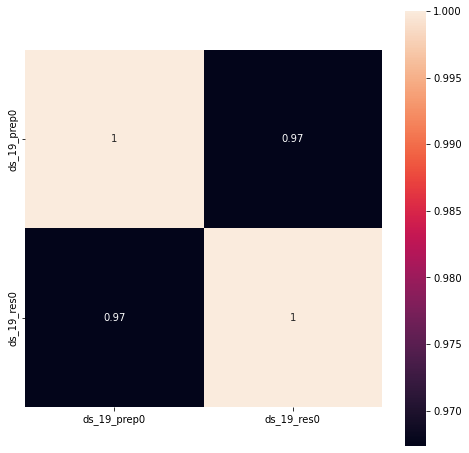

In [47]:
plt.figure(figsize=(8, 8))
sns.heatmap(prediction_df.corr(), square=True, annot=True)
plt.show()

# Error analysis

In [48]:
model_names = oof_df.columns.tolist()
# prediction_df = oof_df

In [49]:
prediction_df['rank_std'] = prediction_df.drop('id', axis=1).rank(0).std(1)

<AxesSubplot:xlabel='rank_std', ylabel='Count'>

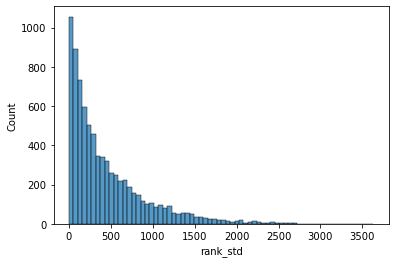

In [50]:
sns.histplot(prediction_df['rank_std'])

In [57]:
valid.head()

id  nonstationary_H1  nonstationary_L1  artifact_H1  artifact_L1  \
0  00054c878                 0                 0            0            0   
1  0007285a3                 0                 0            0            0   
2  00076c5a6                 0                 0            0            0   
3  001349290                 0                 0            0            0   
4  001a52e92                 0                 0            0            0   

   target                                               path          F0  \
0       0  input/g2net-detecting-continuous-gravitational...         NaN   
1       1  input/g2net-detecting-continuous-gravitational...  126.348889   
2       0  input/g2net-detecting-continuous-gravitational...         NaN   
3       1  input/g2net-detecting-continuous-gravitational...   94.908333   
4       0  input/g2net-detecting-continuous-gravitational...         NaN   

             F1   F2     Alpha     Delta            h0      cosi       psi  \
0           NaN  NaN       NaN       NaN           NaN       NaN       NaN   
1 -1.477040e-09  0.0  0.464513  0.202887  1.613816e-25 -0.299837 -0.327641   
2           NaN  NaN       NaN       NaN           NaN       NaN       NaN   
3 -4.871001e-11  0.0  1.222123 -1.011553  1.720702e-25 -0.517167 -0.392569   
4           NaN  NaN       NaN       NaN           NaN       NaN       NaN   

        phi  signal_depth  
0       NaN           NaN  
1  1.002470     30.982465  
2       NaN           NaN  
3  5.284217     29.057907  
4       NaN           NaN

In [59]:
# valid['id'] = valid['id'].str[:-4]
prediction_df = prediction_df.merge(valid[['id', 'nonstationary_H1', 'nonstationary_L1']], on='id', how='left')
# prediction_df = pd.concat([prediction_df, test], axis=1)
# prediction_df = pd.concat([prediction_df, valid], axis=1)

In [39]:
# prediction_df_easy = prediction_df.sort_values('rank_std')
# Path('input/plot/easy/').mkdir(parents=True, exist_ok=True)
# ds = G2Net2022Dataset3(
#     prediction_df_easy.head(5),
#     # data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
#     preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
#     # transforms=ClipSignal(0, 1.5)
# )
# for idx, (specs, _) in enumerate(ds):
#     gid = ds.df.iloc[idx]['id']
#     labels = ds.df[model_names].iloc[idx]
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx}, {np.round(labels.values, 2)}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
#     col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
#     plt.plot(specs[:, col_roi0, 0])
#     plt.plot(specs[:, col_roi1, 1])
#     plt.title(f'time slice ({col_roi0}/{col_roi1})')
#     plt.subplot(1, 4, 4)
#     row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
#     row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
#     plt.plot(specs[row_roi0, :, 0])
#     plt.plot(specs[row_roi1, :, 1])
#     plt.title(f'freq slice ({row_roi0}/{row_roi1})')
#     # plt.savefig(f'input/plot/easy/{gid}.png', facecolor='white')
#     plt.show()
#     plt.close()


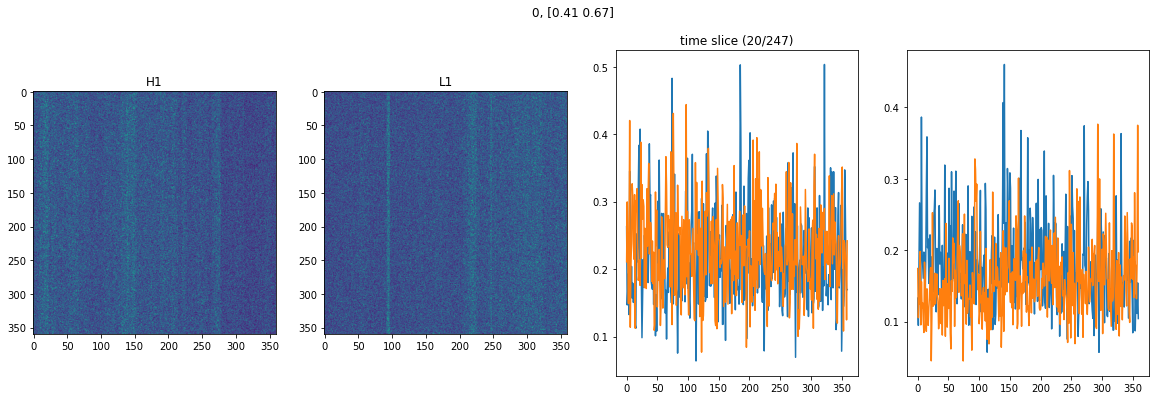

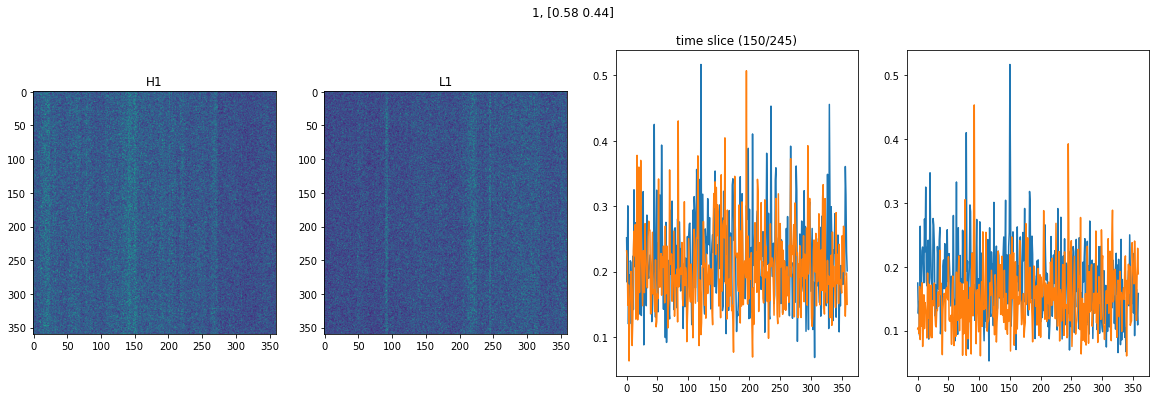

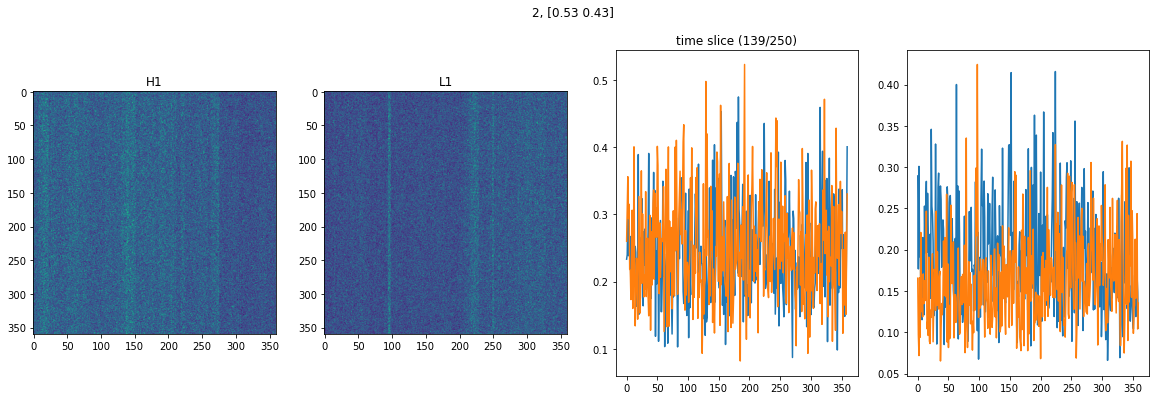

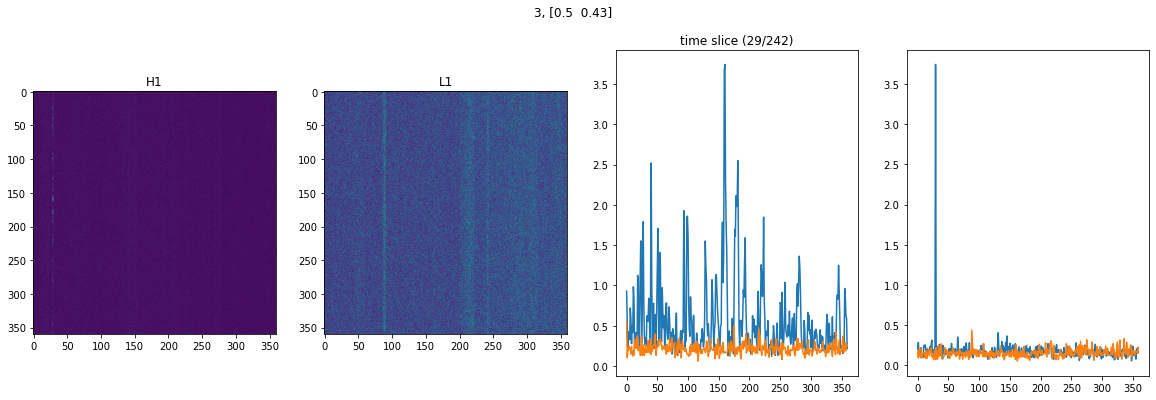

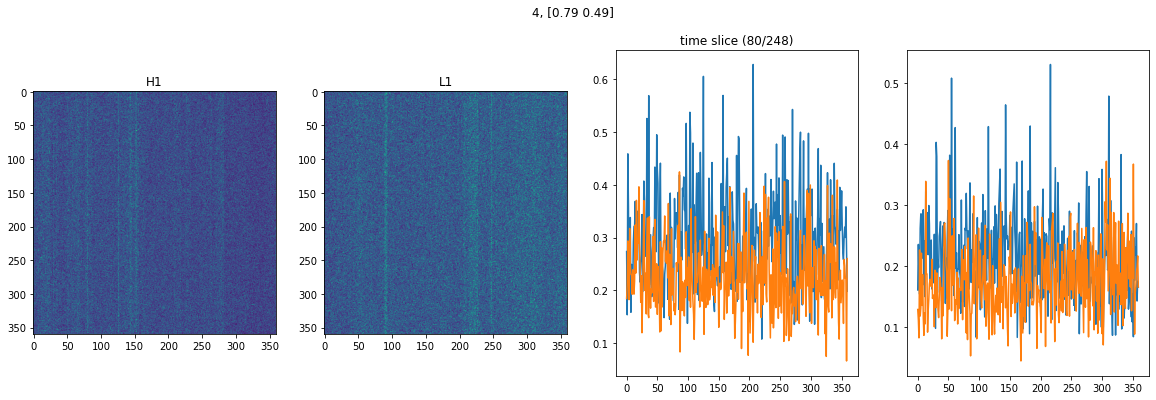

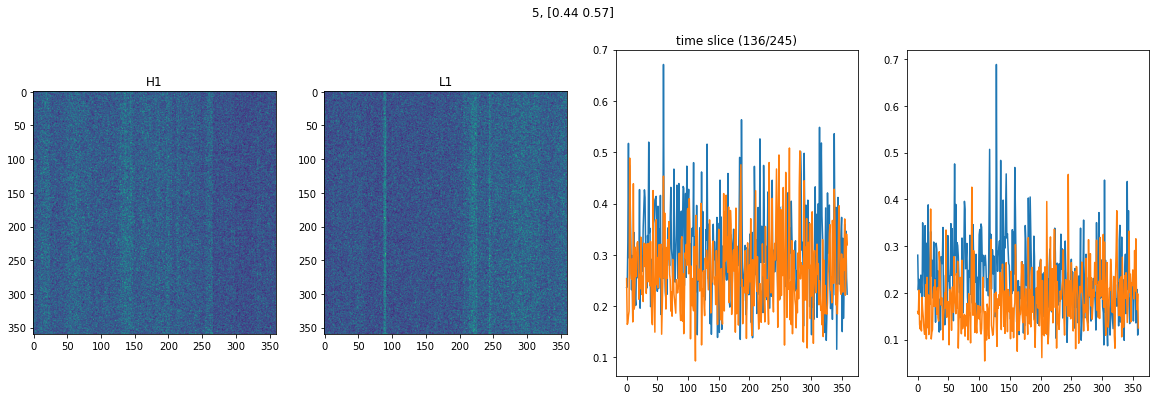

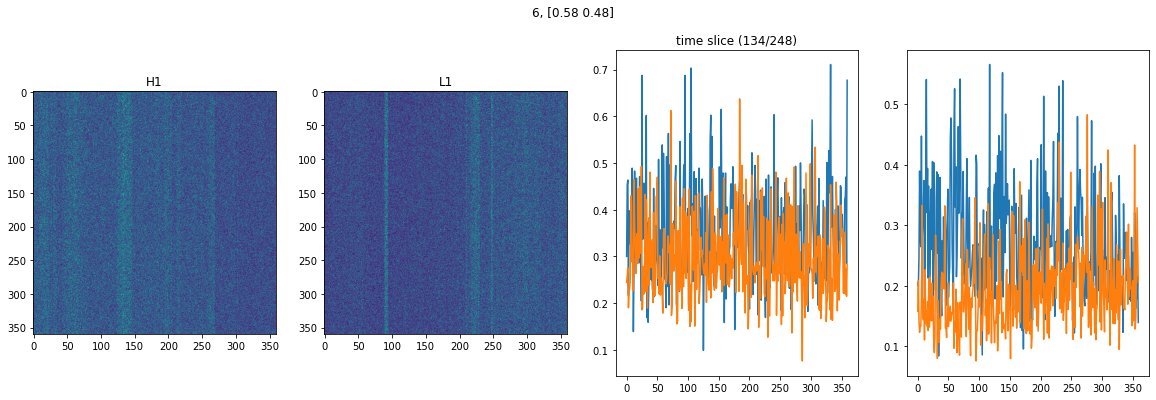

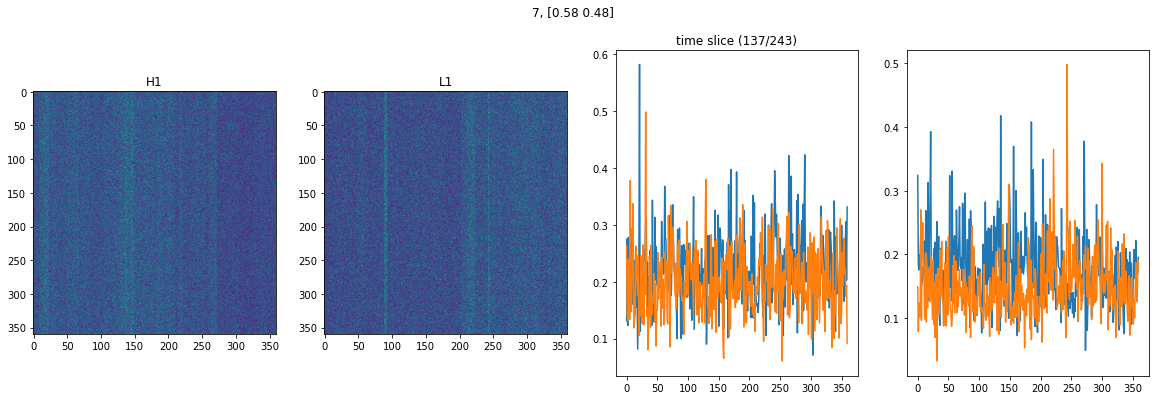

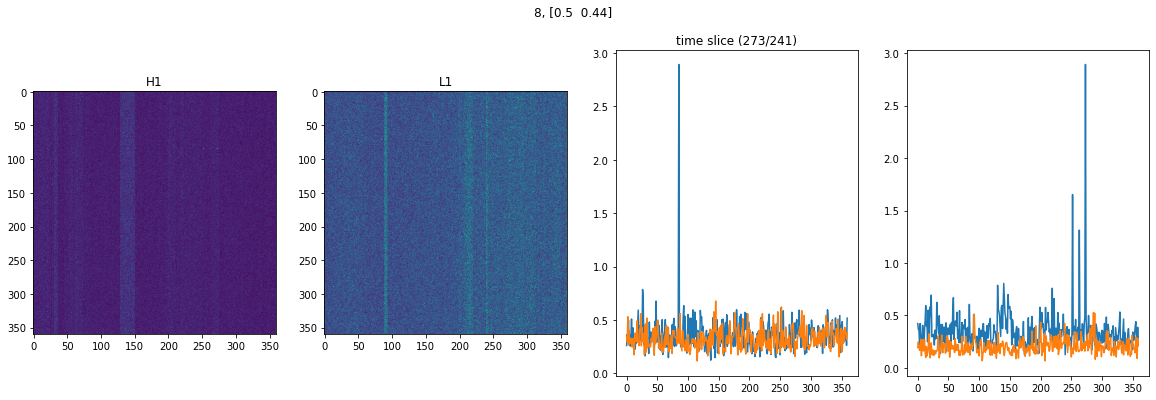

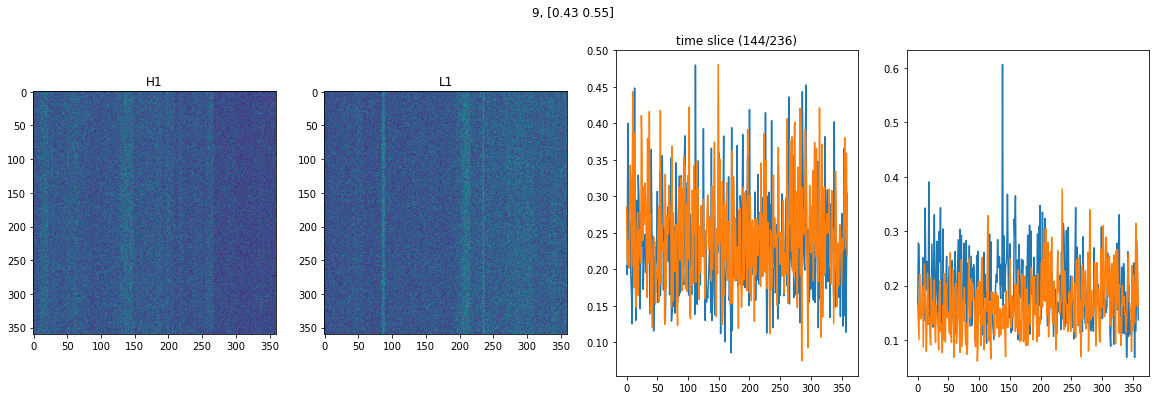

In [63]:
prediction_df_hard = prediction_df.sort_values('rank_std', ascending=False).query(
    'nonstationary_H1 == 1 or nonstationary_L1 == 1')
prediction_df_hard['target'] = 0.5
Path('input/plot/hard/').mkdir(parents=True, exist_ok=True)
ds = G2Net2022Dataset3(
    prediction_df_hard.head(10),
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(img_size=360), NormalizeSpectrogram('constant')]),
    transforms=None,
    # match_time=True
)
for idx, (specs, _) in enumerate(ds):
    gid = prediction_df_hard.iloc[idx]['id']
    labels = prediction_df_hard[model_names[:-1]].iloc[idx]
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}, {np.round(labels.values, 2)}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[:, :, 0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[:, :, 1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
    col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
    plt.plot(specs[:, col_roi0, 0])
    plt.plot(specs[:, col_roi1, 1])
    plt.title(f'time slice ({col_roi0}/{col_roi1})')
    plt.subplot(1, 4, 4)
    row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
    row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
    plt.plot(specs[row_roi0, :, 0])
    plt.plot(specs[row_roi1, :, 1])
    # plt.title(f'freq slice ({row_roi0}/{row_roi1})')
    # plt.savefig(f'input/plot/hard/{gid}.png', facecolor='white')
    plt.show()
    plt.close()

In [19]:
hard_samples = prediction_df.sort_values('rank_std', ascending=False).head(2000)
easy_samples = prediction_df.sort_values('rank_std', ascending=True).iloc[2000:4000]
hard_samples['target2'] = 1
easy_samples['target2'] = 0
ps_data = pd.concat([hard_samples, easy_samples], axis=0)


/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/g2net2022/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Logger created at 22/12/17:13:15:43
Learning rate set to 0.164273
0:	test: 0.5877195	best: 0.5877195 (0)	total: 53ms	remaining: 2.6s
10:	test: 0.6621400	best: 0.6621400 (10)	total: 96.7ms	remaining: 343ms
20:	test: 0.6875567	best: 0.6875567 (20)	total: 126ms	remaining: 175ms
30:	test: 0.7074831	best: 0.7074831 (30)	total: 155ms	remaining: 95.2ms
40:	test: 0.7302466	best: 0.7302466 (40)	total: 187ms	remaining: 41ms
49:	test: 0.7450336	best: 0.7450336 (49)	total: 214ms	remaining: 0us

bestTest = 0.745033625
bestIteration = 49



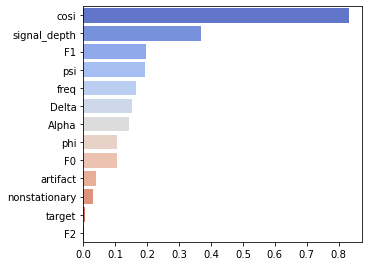

In [20]:
from kuma_utils.training import Trainer
from catboost import CatBoostClassifier

params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 50,
    'use_best_model': True,
} 
fit_params = {
    'early_stopping_rounds': 10,
    'verbose_eval': 10
}

trn = Trainer(CatBoostClassifier)
trn.train(
    train_data=(ps_data.drop(['target2', 'id', 'path', 'base_id', 'rank_std']+model_names, axis=1), ps_data['target2']), 
    params=params, fit_params=fit_params, 
)
trn.plot_feature_importance()


/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/g2net2022/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/g2net2022/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


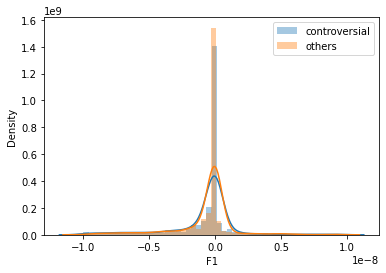

In [30]:
sns.distplot(hard_samples['F1'], label='controversial')
sns.distplot(easy_samples['F1'], label='others')
plt.legend()
plt.show()

In [6]:
# ds = G2Net2022Dataset88(
#     df=pd.read_csv(Path('input/g2net-detecting-continuous-gravitational-waves/v18s.csv')).head(10),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v18s'),
#     noise_path=Path('input/g2net-detecting-continuous-gravitational-waves/concat_v18n1_v18n2.csv'),
#     noise_dir=None,
#     match_time=False,
#     signal_amplifier=1,
#     shift_range=(-165, 165),
#     positive_p=1,
#     noise_mixup_p=0,
#     return_mask=True,
#     # is_test=True,
#     preprocess=A.Compose([
#         ToSpectrogram(), 
#         AdaptiveResize(img_size=360), 
#         NormalizeSpectrogram('constant')]),
#     transforms=None
# )
# for idx, (specs, mask, _) in enumerate(ds):
#     plt.figure(figsize=(15, 5))
#     plt.suptitle(f'{idx}')
#     plt.subplot(1, 3, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.title('H1')
#     plt.subplot(1, 3, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.title('L1')
#     plt.subplot(1, 3, 3)
#     plt.imshow(mask)
#     plt.show()
#     # plt.savefig(f'input/plot/sample/{idx}.png', facecolor='white')
#     plt.close()

# Generate Noise Template

In [ ]:
timenoise_idx = [
    # v0
    '0a9ab0c9e', '0de7c7655', '0e9c2bb33', '1dc9bc740', '1facb0bab', '6b4107dfd', 
    '6ba4c8187', '6ec448e76', '7a1668972', '7dc03113e', '8bfb5c3fe', '8c0e4381a',
    '8f0d3c49c', '64bf3b4cc', '80ce2df12', '250ce99ba', '343fd1262', '371a20194',
    '439ff8b8c', '500ca9751', '838ca3d9e', '8537d2f36', '8603bf1e2', '961624e88',
    '2705507a9', '5310205bd', '38994676c', '82991740d', '227585724', 'a0eeec887',
    'ae967aea1', 'b4c72f14d', 'b176dfe31', 'b267c820d', 'b383cdb39', 'b604b31b5',
    'cdc0d65cb', 'cdeb7fe4a', 'd5b7bf6e3', 'd94f90817', 'e2c46e48a', 'e0696d220',
    'ef559e2d9', 'efb2e3891', 'f090b5877', 
    # v1
    '3da1e0f33', '9c0b5f798', '1928ca4a7', 'a9e280d75', 'dcdf0f575', 
    # v2
    '64a563381', 'df7f170d3', '0a1a06b36', '3bcc523a3', 'e4d6595d9',
    'd93435874', 'b829c1194', '65e192431', 'ceafe2326', 'da86f97af',
    '1b96f2483', 'b7a3bfd36', '5ffa7a8f4', '41154b5f0', '2dbea30b0',
    'd794f8f4e', 'd4e46b35f', '634543900'
]
timenoise_idx = set(timenoise_idx)
ds = G2Net2022Dataset3(
    test.loc[test['id'].isin(timenoise_idx)],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([
        ToSpectrogram(), NormalizeSpectrogram('constant')]),
)

In [ ]:
def extract_noise_template(specs):
    spec_h1, specs_l1 = specs[:, :, 0], specs[:, :, 1]
    return spec_h1.mean(0), specs_l1.mean(0)

In [ ]:
noise_templates = {
    'H1': [],
    'L1': [],
}
for idx, (specs, _) in enumerate(ds):
    tmp_h1, tmp_l1 = extract_noise_template(specs)
    noise_templates['H1'].append(tmp_h1)
    noise_templates['L1'].append(tmp_l1)


In [ ]:
with open('input/timenoise_v2.pickle', 'wb') as f:
    pickle.dump(noise_templates, f)

# Training visualization

In [89]:
from configs import *
from configs_chris import *

In [7]:
# ds = cfg.dataset(
#     pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v12.csv').head(10),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v12'),
#     # transforms=cfg.transforms['train'],
#     transforms=A.Compose([
#         RandomCrop(4096),
#         BandPass(sr=2048),
#         WaveToTensor()]),
#     **cfg.dataset_params
# )

In [20]:
cfg = Ds20()
train = pd.read_csv(cfg.train_path)
ds = cfg.dataset(
    df=train.query('signal_depth < 30 and cosi > 0.5').head(10),
    # df=train.head(),
    # df=train.loc[
    #     train['base_id'].isin(
    #         pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v23v.csv').query('artifact_H1 == 1')['id'].str[:-4])],
    data_dir=cfg.train_dir,
    transforms=cfg.transforms['test'],
    **dict(cfg.dataset_params, **dict(
        signal_amplifier=1, match_time=True, positive_p=1.0, return_mask=True))
)
# ds = cfg.dataset(
#     df=pd.read_csv(cfg.valid_path),
#     data_dir=cfg.valid_dir,
#     transforms=cfg.transforms['test'],
#     is_test=True,
#     **dict(cfg.dataset_params, **dict(signal_amplifier=10))
# )

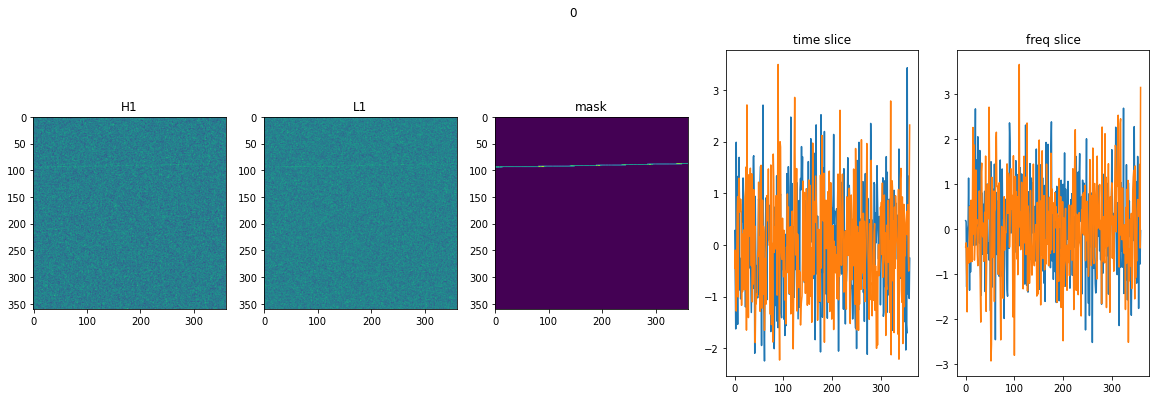

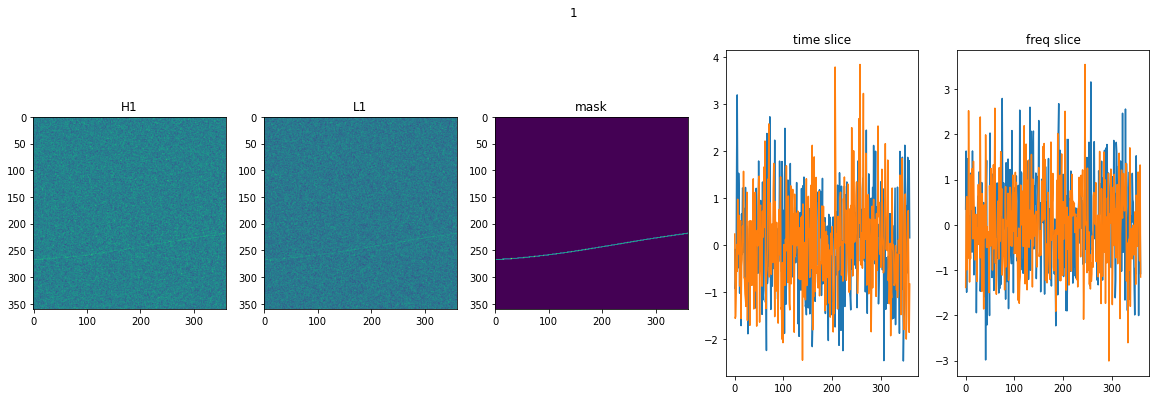

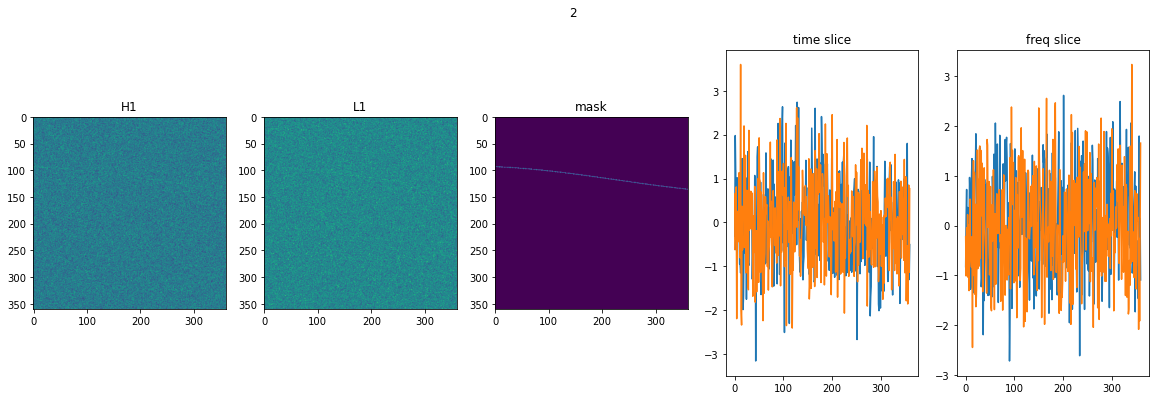

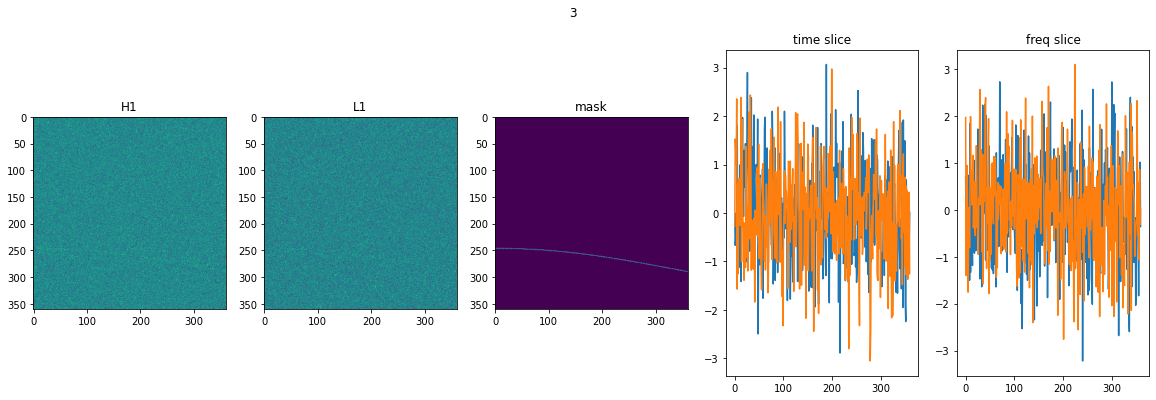

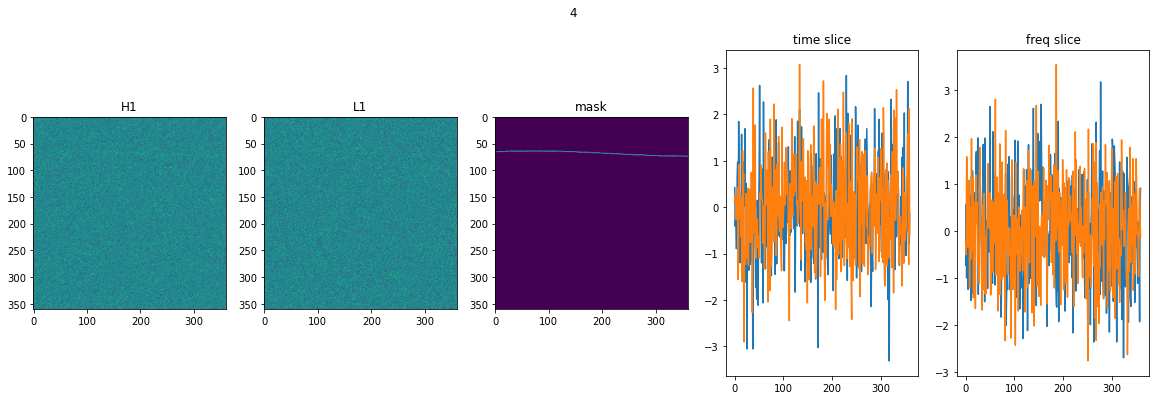

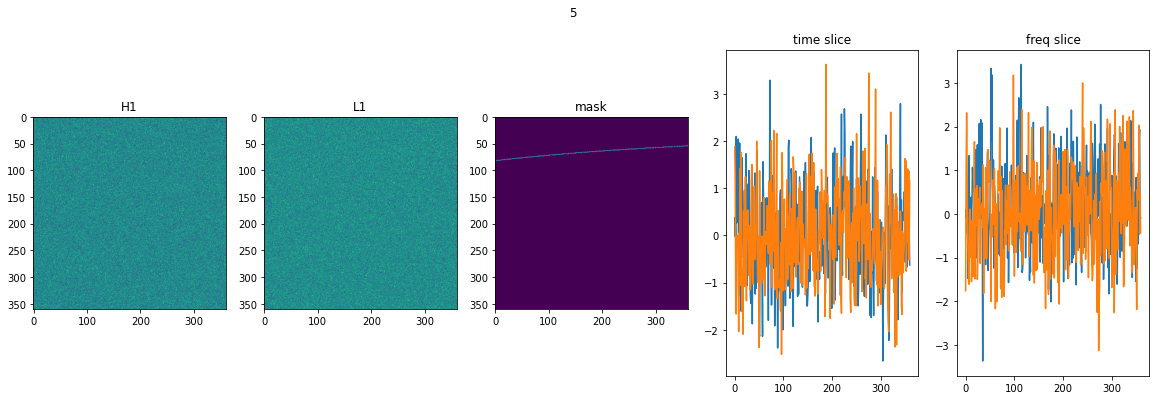

In [21]:
for idx, inputs in enumerate(ds):
    specs = inputs[0]
    mask = inputs[1]
    # specs = (specs - specs.min()) / (specs.max() - specs.min())
    # print(specs.dtype)
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}')
    plt.subplot(1, 5, 1)
    plt.imshow(specs[0])
    plt.title('H1')
    plt.subplot(1, 5, 2)
    plt.imshow(specs[1])
    plt.title('L1')
    plt.subplot(1, 5, 3)
    plt.imshow(mask)
    plt.title('mask')
    plt.subplot(1, 5, 4)
    plt.plot(specs[0, :, 128])
    plt.plot(specs[1, :, 128])
    plt.title(f'time slice')
    plt.subplot(1, 5, 5)
    plt.plot(specs[0, 180, :])
    plt.plot(specs[1, 180, :])
    plt.title(f'freq slice')
    plt.show()
    plt.close()
    if idx == 5:
        break
    

In [82]:
kernels = torch.load('input/g2net-detecting-continuous-gravitational-waves/wave_banks.pt')

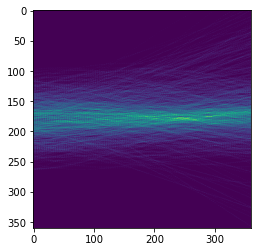

In [86]:
plt.imshow(kernels[:1024, :, :].mean(0))

In [90]:
cfg = Model06()

In [93]:
model = cfg.model(**cfg.model_params)

In [94]:
model(torch.empty(2, 2, 360, 360))

torch.Size([2, 512, 360, 1])
torch.Size([2, 1, 360, 512])


tensor([[nan],
        [nan]], grad_fn=<AddmmBackward0>)

# Noise matching

In [6]:
from configs import *
from configs_chris import *

In [7]:
cfg = Ds18prep3()
model = cfg.model(**cfg.model_params)
checkpoint = torch.load(f'results/{cfg.name}/fold0.pt', 'cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [8]:
kernels = model.preprocess[0].state_dict()['weight']
kernels.shape

torch.Size([64, 2, 3, 31])

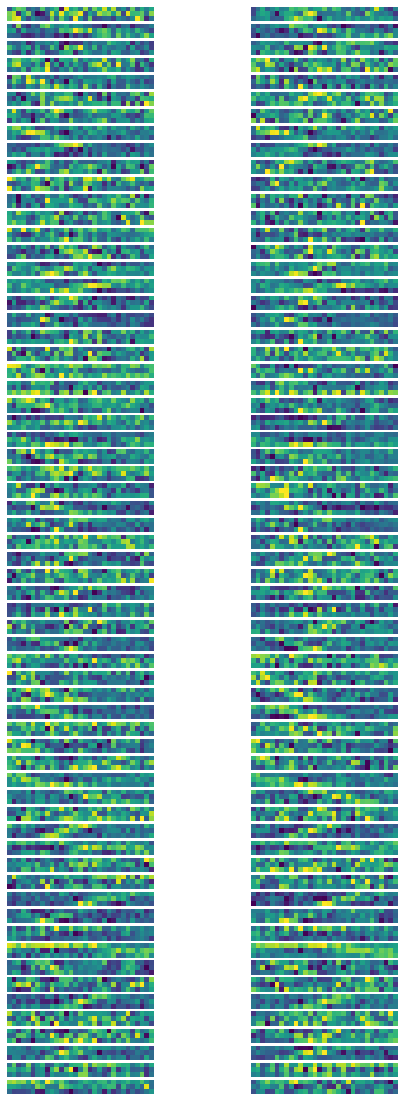

In [9]:
fig = plt.figure(figsize=(8, 20))
for i in range(64):
    for j in range(2):
        plt.subplot(64, 2, i*2+j+1)
        plt.imshow(kernels[i, j])
        plt.axis('off')
plt.show()
plt.close()


In [10]:
cfg = Ds18prep0()
model = cfg.model(**cfg.model_params)
checkpoint = torch.load(f'results/{cfg.name}/fold0.pt', 'cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [11]:
kernels = model.preprocess[0].state_dict()['weight']
kernels.shape

torch.Size([64, 2, 3, 31])

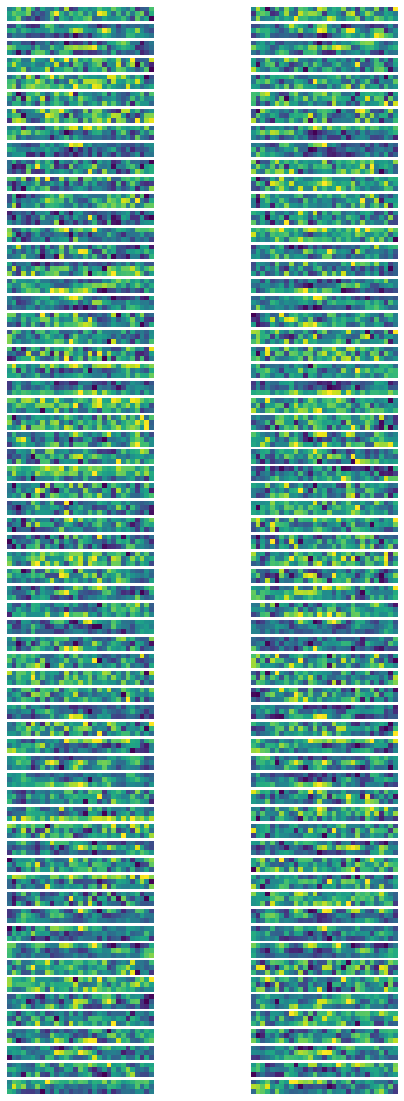

In [12]:
fig = plt.figure(figsize=(8, 20))
for i in range(64):
    for j in range(2):
        plt.subplot(64, 2, i*2+j+1)
        plt.imshow(kernels[i, j])
        plt.axis('off')
plt.show()
plt.close()
